In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from cartiflette import carti_download
import plotly.express as px
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler


## Import Données

In [46]:
df_patientele = pd.read_csv("Bases de données/Données_Patientele_Departementale.csv", sep=";")
df_patientele['nombre_patients_uniques'] = pd.to_numeric(df_patientele['nombre_patients_uniques'],errors='coerce')
df_patientele.columns = df_patientele.columns.str.replace("\ufeff", "", regex=False).str.strip()

df_patientele_2017 = df_patientele[(df_patientele['annee'] == 2017) & (df_patientele['profession_sante'] == "Médecins généralistes (hors médecins à expertise particulière - MEP)")]
df_patientele_2017 = df_patientele_2017[["departement","libelle_departement","patients_uniques_integer"]]
df_patientele_2017.columns = ["Code Département","Département","Nb de patients unique par spécialiste"]
df_patientele_2017.head()
print(df_patientele_2017.shape)

(120, 3)


In [47]:
df_Indicateurs_département = pd.read_excel("Bases de données/Indicateur_Departementale.xlsx")
df_Indicateurs_département.columns = ["Code Département", "Libellé Département", "Nombre de décès domiciliés 2024", "Salaire net EQTP mensuel moyen 2023","Espérance de vie des hommes à 60 ans 2024",	"Espérance de vie des femmes à 60 ans","Taux d'activité","Taux de chômage annuel moyen 2024","Part des résidences principales en suroccupation","Taux de pauvreté - familles monoparentales 2021","Taux de pauvreté 2021","Médiane du niveau de vie 2021","Taux brut de mortalité 2024","Taux de natalité 2024"]
df_Indicateurs_département = df_Indicateurs_département.sort_values(by="Code Département")

df_Indicateurs_département.head()

,Code Département,Libellé Département,Nombre de décès domiciliés 2024,Salaire net EQTP mensuel moyen 2023,Espérance de vie des hommes à 60 ans 2024,Espérance de vie des femmes à 60 ans,Taux d'activité,Taux de chômage annuel moyen 2024,Part des résidences principales en suroccupation,Taux de pauvreté - familles monoparentales 2021,Taux de pauvreté 2021,Médiane du niveau de vie 2021,Taux brut de mortalité 2024,Taux de natalité 2024
3,01,Ain,5405,2490,24.5,27.8,79,5.6,0.4,24,10.8,24810,7.9,9
4,02,Aisne,5674,2287,22,26.3,73.4,10.5,0.4,38,18.8,20920,11,9
5,03,Allier,4494,2250,23,27.5,74,7.9,0.2,34.5,16.2,21500,13.5,7.5
6,04,Alpes-de-Haute-Provence,2032,2217,23.9,28,74.4,7.9,0.4,34.1,17.1,21790,11.8,7.7
7,05,Hautes-Alpes,1517,2189,24.7,29,77,6.2,0.3,30.4,14.7,22010,10.6,7.7


In [5]:
df_Indicateurs_Commune = pd.read_csv("Bases de données/Indicateurs_communale.csv", sep=";", low_memory=False)
Noms_cols = df_Indicateurs_Commune.loc[1].astype(str).tolist()
df_Indicateurs_Commune.columns = Noms_cols
A_supprimer = ["Médecin généraliste (en nombre) 2024",
    "Supérette - Épicerie (en nombre) 2024", 
    "Boulangerie-pâtisserie (en nombre) 2024",
    "Salles multisports (gymnases) (en nombre) 2024",
    "École maternelle, primaire, élémentaire (en nombre) 2024",
    "Collège (en nombre) 2024", 
    "Lycée (en nombre) 2024",
    "Code",
    "Libellé"]
Noms_cols_explicatives = [c for c in Noms_cols if c not in A_supprimer]
Noms_cols_explicatives.append("Commerce et infrastructures (en nombre) 2024")
Noms_cols_explicatives.append("Etablissement d'éducation (en nombre) 2024")
print(Noms_cols)

df_Indicateurs_Commune = df_Indicateurs_Commune[2:]

df_Indicateurs_Commune["Code"] = df_Indicateurs_Commune["Code"].astype(str).str.strip()
df_Indicateurs_Commune = df_Indicateurs_Commune.sort_values(by="Code")

Commerce = ["Supérette - Épicerie (en nombre) 2024", "Boulangerie-pâtisserie (en nombre) 2024","Salles multisports (gymnases) (en nombre) 2024"]
Education = ["École maternelle, primaire, élémentaire (en nombre) 2024", "Collège (en nombre) 2024", "Lycée (en nombre) 2024"]

df_Indicateurs_Commune["Commerce et infrastructures (en nombre) 2024"] = df_Indicateurs_Commune[Commerce].sum(axis=1)
df_Indicateurs_Commune["Etablissement d'éducation (en nombre) 2024"] = df_Indicateurs_Commune[Education].sum(axis=1)

df_Indicateurs_Commune = df_Indicateurs_Commune.drop(columns=Commerce)
df_Indicateurs_Commune = df_Indicateurs_Commune.drop(columns=Education)

df_Indicateurs_Commune = df_Indicateurs_Commune.replace("N/A - résultat non disponible",np.nan)
df_Indicateurs_Commune = df_Indicateurs_Commune.replace("N/A - secret statistique",np.nan)
df_Indicateurs_Commune = df_Indicateurs_Commune.replace("N/A - division par 0",np.nan)
df_Indicateurs_Commune = df_Indicateurs_Commune.replace("N/A - résultat non disponibleN/A - résultat non disponibleN/A - résultat non disponible",np.nan)
df_Indicateurs_Commune = df_Indicateurs_Commune.replace("N/A - division par 0",np.nan)




df_Indicateurs_Commune.head()

['Code', 'Libellé', 'Population de 15 ans ou + selon le groupe socioprofessionnel actuel ou antérieur 2022 Artisans, commerçants, chefs entreprise', 'Médiane du niveau de vie 2021', 'Police - Gendarmerie (en nombre) 2024', 'Supérette - Épicerie (en nombre) 2024', 'Boulangerie-pâtisserie (en nombre) 2024', 'École maternelle, primaire, élémentaire (en nombre) 2024', 'Collège (en nombre) 2024', 'Lycée (en nombre) 2024', 'Salles multisports (gymnases) (en nombre) 2024', "Nombre d'établissements 2023", "Nb d'hôtels 2025", 'Médecin généraliste (en nombre) 2024', 'Population municipale 2023', 'Population de 15 ans ou + selon le groupe socioprofessionnel actuel ou antérieur 2022 Ensemble', 'Population de 15 ans ou + selon le groupe socioprofessionnel actuel ou antérieur 2022 Agriculteurs exploitants', 'Population de 15 ans ou + selon le groupe socioprofessionnel actuel ou antérieur 2022 Cadres et professions intellectuelles supérieures', 'Population de 15 ans ou + selon le groupe socioprofessi

,Code,Libellé,"Population de 15 ans ou + selon le groupe socioprofessionnel actuel ou antérieur 2022 Artisans, commerçants, chefs entreprise",Médiane du niveau de vie 2021,Police - Gendarmerie (en nombre) 2024,Nombre d'établissements 2023,Nb d'hôtels 2025,Médecin généraliste (en nombre) 2024,Population municipale 2023,Population de 15 ans ou + selon le groupe socioprofessionnel actuel ou antérieur 2022 Ensemble,...,Taux d'activité par tranche d'âge 2022 55 à 64 ans,Part des pers. âgées de - 15 ans 2022,Part des pers. âgées de - de 25 ans 2022,Part des pers. âgées de 25 à 64 ans 2022,Part des pers. âgées de 75 ans ou + 2022,Part des familles avec 1 enf. de - de 25 ans 2022,Part des familles avec 2 enf. de - de 25 ans 2022,Part des familles avec 3 enf. ou plus de - de 25 ans 2022,Commerce et infrastructures (en nombre) 2024,Etablissement d'éducation (en nombre) 2024
2,01001,L'Abergement-Clémenciat,39,25820,0,16,0,0,860,692,...,61.8,18.9,26.5,53.4,8.8,25.5,18.2,7.3,000,100
3,01002,L'Abergement-de-Varey,5,24480,0,4,0,0,270,199,...,61.5,20.9,30,51.6,8.4,18.7,31.3,6.2,000,000
4,01004,Ambérieu-en-Bugey,392,21660,1,599,1,25,15934,12595,...,62.1,19.2,32.6,49.3,8.8,21.9,18.7,12.7,5146,722
5,01005,Ambérieux-en-Dombes,102,24610,0,45,2,1,1906,1542,...,58.9,18.9,27.8,55.2,7.3,22.7,20.6,6.8,110,100
6,01006,Ambléon,0,24210,0,1,0,0,115,98,...,45.8,8.8,15.8,56.1,7,50,0,0,000,000


## Merging & Nettoyage

In [49]:
df_Indicateurs_département["Code Département"] = (df_Indicateurs_département["Code Département"].astype(str).str.zfill(2))
df_patientele_2017["Code Département"] = (df_patientele_2017["Code Département"].astype(str).str.zfill(2))

In [50]:
df = df_patientele_2017.merge(df_Indicateurs_département, on="Code Département", how="inner")
df = df.drop(columns=["Libellé Département"])
df = df.replace("N/A - résultat non disponible",np.nan)
df.head()

/tmp/ipykernel_141179/1291448598.py:3: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



,Code Département,Département,Nb de patients unique par spécialiste,Nombre de décès domiciliés 2024,Salaire net EQTP mensuel moyen 2023,Espérance de vie des hommes à 60 ans 2024,Espérance de vie des femmes à 60 ans,Taux d'activité,Taux de chômage annuel moyen 2024,Part des résidences principales en suroccupation,Taux de pauvreté - familles monoparentales 2021,Taux de pauvreté 2021,Médiane du niveau de vie 2021,Taux brut de mortalité 2024,Taux de natalité 2024
0,971,Guadeloupe,1788.0,3839,2406.0,23.4,26.7,70.6,16.8,1.4,NaN,NaN,NaN,10.5,9.2
1,976,Mayotte,3166.0,1011,NaN,18.0,20.4,NaN,NaN,NaN,NaN,NaN,NaN,3.1,27.7
2,75,Paris,1355.0,14079,3863.0,25.2,28.7,78.7,5.7,2.7,24.6,15.6,29730.0,6.8,10.5
3,91,Essonne,1858.0,8880,2923.0,24.7,28.2,76.3,6.5,2.0,24.8,13.9,25040.0,6.6,12.8
4,39,Jura,1536.0,2975,2357.0,23.5,27.3,76.8,5.3,0.3,25.3,11.8,23140.0,11.7,7.4


In [51]:
cols_num = ["Nb de patients unique par spécialiste", "Nombre de décès domiciliés 2024", "Salaire net EQTP mensuel moyen 2023","Espérance de vie des hommes à 60 ans 2024",	"Espérance de vie des femmes à 60 ans","Taux d'activité","Taux de chômage annuel moyen 2024","Part des résidences principales en suroccupation","Taux de pauvreté - familles monoparentales 2021","Taux de pauvreté 2021","Médiane du niveau de vie 2021","Taux brut de mortalité 2024","Taux de natalité 2024"]

for col in cols_num:
    df[col] = pd.to_numeric(df[col],errors="coerce")

print(df.shape)
df.head()

(101, 15)


,Code Département,Département,Nb de patients unique par spécialiste,Nombre de décès domiciliés 2024,Salaire net EQTP mensuel moyen 2023,Espérance de vie des hommes à 60 ans 2024,Espérance de vie des femmes à 60 ans,Taux d'activité,Taux de chômage annuel moyen 2024,Part des résidences principales en suroccupation,Taux de pauvreté - familles monoparentales 2021,Taux de pauvreté 2021,Médiane du niveau de vie 2021,Taux brut de mortalité 2024,Taux de natalité 2024
0,971,Guadeloupe,1788.0,3839,2406.0,23.4,26.7,70.6,16.8,1.4,NaN,NaN,NaN,10.5,9.2
1,976,Mayotte,3166.0,1011,NaN,18.0,20.4,NaN,NaN,NaN,NaN,NaN,NaN,3.1,27.7
2,75,Paris,1355.0,14079,3863.0,25.2,28.7,78.7,5.7,2.7,24.6,15.6,29730.0,6.8,10.5
3,91,Essonne,1858.0,8880,2923.0,24.7,28.2,76.3,6.5,2.0,24.8,13.9,25040.0,6.6,12.8
4,39,Jura,1536.0,2975,2357.0,23.5,27.3,76.8,5.3,0.3,25.3,11.8,23140.0,11.7,7.4


In [ ]:
df_Indicateurs_Commune = df_Indicateurs_Commune.replace("N/A - résultat non disponible",np.nan)
df_Indicateurs_Commune = df_Indicateurs_Commune.replace("N/A - secret statistique",np.nan)
df_Indicateurs_Commune = df_Indicateurs_Commune.replace("N/A - division par 0",np.nan)
df_Indicateurs_Commune = df_Indicateurs_Commune.replace("N/A - résultat non disponibleN/A - résultat non disponibleN/A - résultat non disponible",np.nan)
df_Indicateurs_Commune = df_Indicateurs_Commune.replace("N/A - division par 0",np.nan)




## Régression linéaire

In [53]:
y = df["Nb de patients unique par spécialiste"]

In [54]:
X_cols = [
    "Salaire net EQTP mensuel moyen 2023",
    "Taux de chômage annuel moyen 2024",
    "Médiane du niveau de vie 2021",
    "Taux de natalité 2024",
    "Espérance de vie des hommes à 60 ans 2024",
    "Part des résidences principales en suroccupation"
]

In [55]:
X = df[X_cols]
df_reg = pd.concat([y, X], axis=1).dropna()
print(df_reg.shape)

y_reg = df_reg[y.name]
X_reg = df_reg[X_cols]

(98, 7)


In [56]:
X_reg = sm.add_constant(X_reg)

In [57]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(df_reg[X_cols])

X_scaled = pd.DataFrame(
    X_scaled,
    columns=X_cols,
    index=df_reg.index
)

X_scaled = sm.add_constant(X_scaled)

model = sm.OLS(y_reg, X_scaled)
results = model.fit()

print(results.summary())

                                      OLS Regression Results                                     
Dep. Variable:     Nb de patients unique par spécialiste   R-squared:                       0.437
Model:                                               OLS   Adj. R-squared:                  0.400
Method:                                    Least Squares   F-statistic:                     11.78
Date:                                   Sun, 28 Dec 2025   Prob (F-statistic):           9.73e-10
Time:                                           09:22:32   Log-Likelihood:                -607.18
No. Observations:                                     98   AIC:                             1228.
Df Residuals:                                         91   BIC:                             1246.
Df Model:                                              6                                         
Covariance Type:                               nonrobust                                         
                    

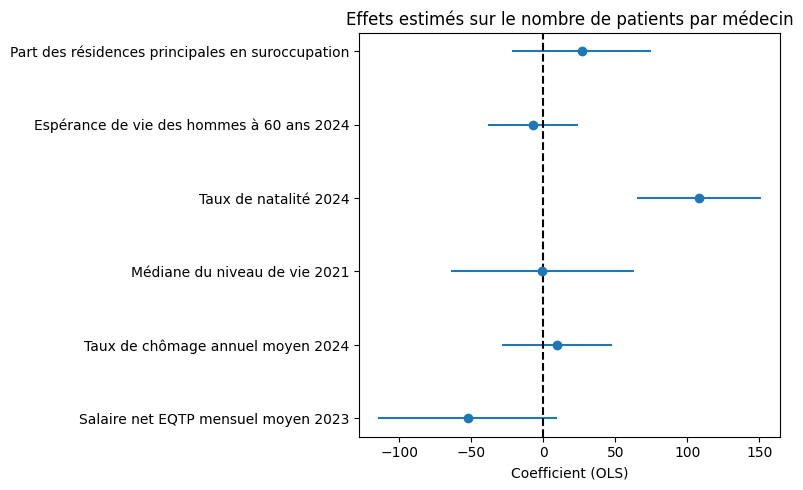

In [58]:
coef = results.params
conf = results.conf_int()
conf.columns = ["lower", "upper"]

coef = coef.drop("const")
conf = conf.drop("const")

plt.figure(figsize=(8, 5))
plt.errorbar(
    coef,
    coef.index,
    xerr=[coef - conf["lower"], conf["upper"] - coef],
    fmt="o"
)
plt.axvline(0, color="black", linestyle="--")
plt.title("Effets estimés sur le nombre de patients par médecin")
plt.xlabel("Coefficient (OLS)")
plt.ylabel("")
plt.tight_layout()
plt.show()


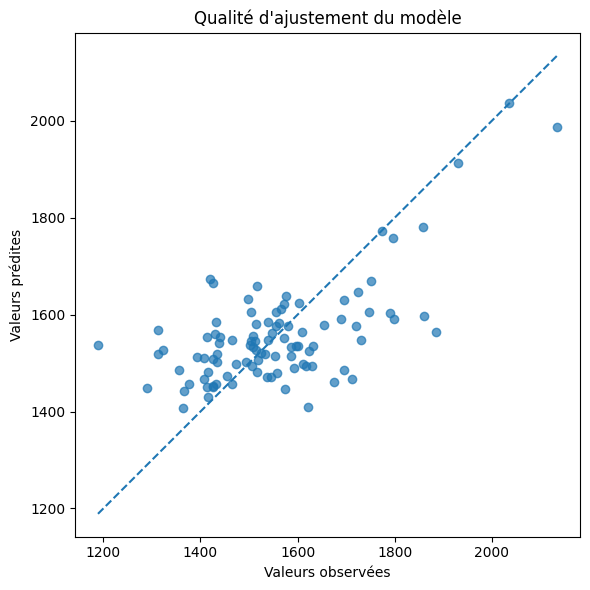

In [59]:
y_pred = results.fittedvalues

plt.figure(figsize=(6, 6))
plt.scatter(y_reg, y_pred, alpha=0.7)
plt.plot(
    [y_reg.min(), y_reg.max()],
    [y_reg.min(), y_reg.max()],
    linestyle="--"
)

plt.xlabel("Valeurs observées")
plt.ylabel("Valeurs prédites")
plt.title("Qualité d'ajustement du modèle")
plt.tight_layout()
plt.show()


In [60]:
def plot_corr_heatmap(
    df: pd.DataFrame,
    drop_cols=None,
    column_labels: dict | None = None,
    decimals: int = 2,
    width: int = 600,
    height: int = 600,
    show_xlabels: bool = False
):
    """
    Trace une heatmap de corrélation (triangle inférieur) à partir d'un DataFrame.

    Paramètres
    ----------
    df : pd.DataFrame
        DataFrame d'entrée.
    drop_cols : list ou None
        Liste de colonnes à supprimer avant le calcul de la corrélation
        (ex: ['winner']).
    column_labels : dict ou None
        Dictionnaire pour renommer les colonnes (ex: column_labels).
    decimals : int
        Nombre de décimales pour l'arrondi avant corr().
    width, height : int
        Dimensions de la figure Plotly.
    show_xlabels : bool
        Afficher ou non les labels en abscisse.
    """
    data = df.copy()

    # 1. Colonnes à drop
    if drop_cols is not None:
        data = data.drop(columns=drop_cols)

    # 2. Arrondi + renommage éventuel
    if column_labels is not None:
        data = data.rename(columns=column_labels)
    data = data.round(decimals)

    # 3. Matrice de corrélation
    corr = data.corr()

    # 4. Masque triangle supérieur
    mask = np.triu(np.ones_like(corr, dtype=bool))
    corr_masked = corr.mask(mask)

    # 5. Heatmap Plotly
    fig = px.imshow(
        corr_masked.values,
        x=corr.columns,
        y=corr.columns,
        color_continuous_scale='RdBu_r',  # échelle inversée
        zmin=-1,
        zmax=1,
        text_auto=".2f"
    )

    # 6. Hover custom
    fig.update_traces(
        hovertemplate="Var 1: %{y}<br>Var 2: %{x}<br>Corr: %{z:.2f}<extra></extra>"
    )

    # 7. Layout
    fig.update_layout(
        coloraxis_showscale=False,
        xaxis=dict(
            showticklabels=show_xlabels,
            title=None,
            ticks=''
        ),
        yaxis=dict(
            showticklabels=show_xlabels,
            title=None,
            ticks=''
        ),
        plot_bgcolor="rgba(0,0,0,0)",
        margin=dict(t=10, b=10, l=10, r=10),
        width=width,
        height=height
    )

    return fig


df_Indicateurs_Commune_Correlation = df_Indicateurs_Commune.drop(columns=["Code", "Libellé"])
plot_corr_heatmap(df_Indicateurs_Commune_Correlation)

In [6]:
def plot_corr_with_target(
    df: pd.DataFrame,
    target: str,
    drop_cols=None,
    decimals: int = 2,
    width: int = 500,
    height: int = 900
):
    """
    Trace une heatmap des corrélations entre une variable cible
    et les autres variables du DataFrame.
    """
    data = df.copy()

    if drop_cols is not None:
        data = data.drop(columns=drop_cols)

    data = data.round(decimals)

    # Corrélation avec la variable cible
    corr = data.corr()[[target]].sort_values(by=target)

    fig = px.imshow(
        corr.values,
        x=[target],
        y=corr.index,
        color_continuous_scale="RdBu_r",
        zmin=-1,
        zmax=1,
        text_auto=".2f"
    )

    fig.update_traces(
        hovertemplate="Variable: %{y}<br>Corr: %{z:.2f}<extra></extra>"
    )

    fig.update_layout(
        coloraxis_showscale=False,
        xaxis_title=None,
        yaxis_title=None,
        width=width,
        height=height,
        margin=dict(t=20, b=20, l=20, r=20)
    )

    return fig


df_Indicateurs_Commune_Correlation = df_Indicateurs_Commune.drop(columns=["Code", "Libellé"])
plot_corr_with_target(df_Indicateurs_Commune_Correlation,"Médecin généraliste (en nombre) 2024")

In [62]:
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.linear_model import lasso_path
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso

In [ ]:
df_Indicateurs_Commune = df_Indicateurs_Commune.apply(pd.to_numeric,errors="coerce")
df_Indicateurs_Reg = df_Indicateurs_Commune[Noms_cols_explicatives+["Médecin généraliste (en nombre) 2024"]]
df_Indicateurs_Reg = df_Indicateurs_Reg.dropna()

X = df_Indicateurs_Reg[Noms_cols_explicatives]
y = df_Indicateurs_Reg["Médecin généraliste (en nombre) 2024"]


Population de 15 ans ou + selon le groupe socioprofessionnel actuel ou antérieur 2022    float64
Population de 15 ans ou + selon le groupe socioprofessionnel actuel ou antérieur 2022    float64
Population de 15 ans ou + selon le groupe socioprofessionnel actuel ou antérieur 2022    float64
Population de 15 ans ou + selon le groupe socioprofessionnel actuel ou antérieur 2022    float64
Population de 15 ans ou + selon le groupe socioprofessionnel actuel ou antérieur 2022    float64
                                                                                          ...   
Part des familles avec 1 enf. de - de 25 ans 2022                                        float64
Part des familles avec 2 enf. de - de 25 ans 2022                                        float64
Part des familles avec 3 enf. ou plus de - de 25 ans 2022                                float64
Commerce et infrastructures (en nombre) 2024                                             float64
Etablissement d'éducation (en 

In [105]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lasso = LassoCV(cv=5).fit(X_scaled, y)

coef_lasso = pd.Series(lasso.coef_, index=X.columns)
coef_lasso[coef_lasso != 0]

Population de 15 ans ou + selon le groupe socioprofessionnel actuel ou antérieur 2022     4.959079
Population de 15 ans ou + selon le groupe socioprofessionnel actuel ou antérieur 2022    13.292767
Population de 15 ans ou + selon le groupe socioprofessionnel actuel ou antérieur 2022    -0.035854
Population de 15 ans ou + selon le groupe socioprofessionnel actuel ou antérieur 2022     0.487845
Population de 15 ans ou + selon le groupe socioprofessionnel actuel ou antérieur 2022    -0.121818
                                                                                           ...    
Nb de terrains de camping 2025                                                           -0.056818
Taille moyenne des ménages 2022                                                          -0.143959
Densité de population (historique depuis 1876) 2022                                      -1.376894
Part des pers. âgées de 75 ans ou + 2022                                                  0.030023
Etablissem

In [ ]:
vars_sel = coef_lasso[coef_lasso != 0].index.tolist()

X_final = sm.add_constant(X[vars_sel])
results = sm.OLS(y, X_final).fit()

print(results.summary())

In [103]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline



X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0)
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
# The pipeline can be used as any other estimator
# and avoids leaking the test set into the train set
pipe.fit(X_train, y_train).score(X_test, y_test)
0.88
# An estimator's parameter can be set using '__' syntax
pipe.set_params(svc__C=10).fit(X_train, y_train).score(X_test, y_test)
0.76

0.76

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

df2.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(
    df2.drop(["per_gop"], axis = 1),
    100*df2['per_gop'], test_size=0.2, random_state=0
)

numerical_features = X_train.select_dtypes(include='number').columns.tolist()
categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()

numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
])

preprocessed_features = pd.DataFrame(
  numeric_pipeline.fit_transform(
    X_train.drop(columns = categorical_features)
  )
)

numeric_pipeline 

NameError: name 'df2' is not defined

In [ ]:

numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numerical_features),
    ('category', categorical_pipeline, categorical_features)
])

model = Lasso(
  fit_intercept=False, 
  alpha = lcv.alpha_
)  

lasso_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', model)
])

lasso_optimal = lasso_pipeline.fit(X_train,y_train)

features_selec2 = extract_features_selected(lasso_optimal)